In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [2]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [57]:
subjects[0].dynamics

array([[ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.],
       [-0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -0.,  0.,  0.,  0.,  0.]], dtype=float32)

## hit counts

In [3]:
subject_target_hits = []
for subject in subjects:
    target_hits = np.zeros(shape=(12))
    sessions = subject.tasks["center_hold"].sorted_sessions()
    for target_no in range(1,13):
        target_hit_count = 0
        for session in sessions:
            for trial in session.sorted_trials():
                if target_no == trial.target_number and trial.outcome == "Hit":
                    target_hit_count += 1
        target_hits[target_no-1] = target_hit_count
    subject_target_hits.append(target_hits)
subject_target_hits = np.array(subject_target_hits)

In [4]:
subject_hit_sums = subject_target_hits.sum(axis=1)/540

## load data

In [5]:
subject_movement_stacks = np.load("subject_movement_stacks.npy")
print(subject_movement_stacks.shape)

subject_calibration_stacks = np.load("subject_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

# subject, session, target, channel, time
subject_emg_stacks = np.transpose(np.load("subject_emg_stacks.npy"),(0,1,2,4,3))
print(subject_emg_stacks.shape)

subject_traj_stacks = np.transpose(np.load("subject_traj_stacks.npy"),(0,1,2,4,3))
print(subject_traj_stacks.shape)

(46, 2, 14, 64, 1800)
(46, 2, 32, 64, 1000)
(46, 45, 12, 64, 1072)
(46, 45, 12, 2, 1070)


## reconstruct trajectory data with GMMs

In [6]:
# subject_gmms = []
# for subject_idx in range(46):
#     trial_samples_channels = subject_emg_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)
#     no_nans = analysis.remove_nan_rows(trial_samples_channels)
#     subject_gmms.append(GaussianMixture(n_components=4, random_state=0, max_iter=200).fit(no_nans))

In [7]:
# dump(subject_gmms, 'subject_trial_gmm_models.joblib')

In [8]:
subject_gmms = load('subject_trial_gmm_models.joblib')

The more gaussians are fit, the more spread out they get... GMM is fitting hot, reliable channels, then getting into larger subspaces?

## how good are the fits?

In [9]:
subject_model_scores = []
for subject_idx in range(46):
    trial_samples_channels = subject_emg_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)
    no_nans = analysis.remove_nan_rows(trial_samples_channels)
    subject_model_scores.append(subject_gmms[subject_idx].score(no_nans))

(array([ 2.,  1.,  3., 10.,  7., 12.,  5.,  4.,  0.,  2.]),
 array([ 76.04109494,  85.06712646,  94.09315797, 103.11918948,
        112.14522099, 121.17125251, 130.19728402, 139.22331553,
        148.24934704, 157.27537856, 166.30141007]),
 <BarContainer object of 10 artists>)

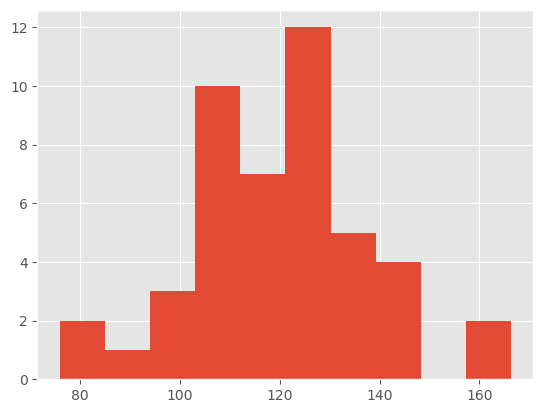

In [10]:
plt.hist(subject_model_scores)

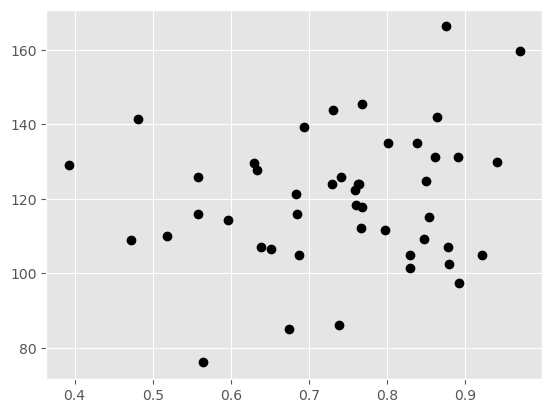

In [11]:
plt.plot(subject_hit_sums, subject_model_scores,"ko")

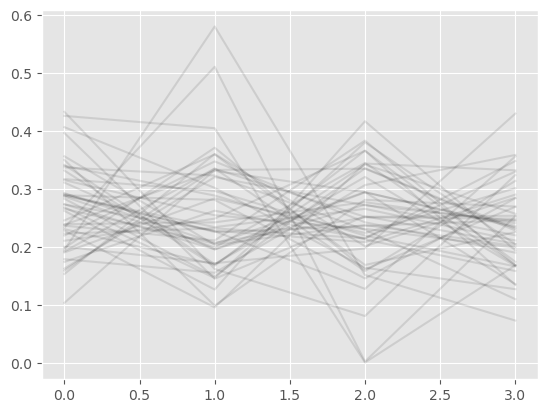

In [12]:
for gm in subject_gmms:
    plt.plot(gm.weights_,"k",alpha=0.1)

## inspect test subject components

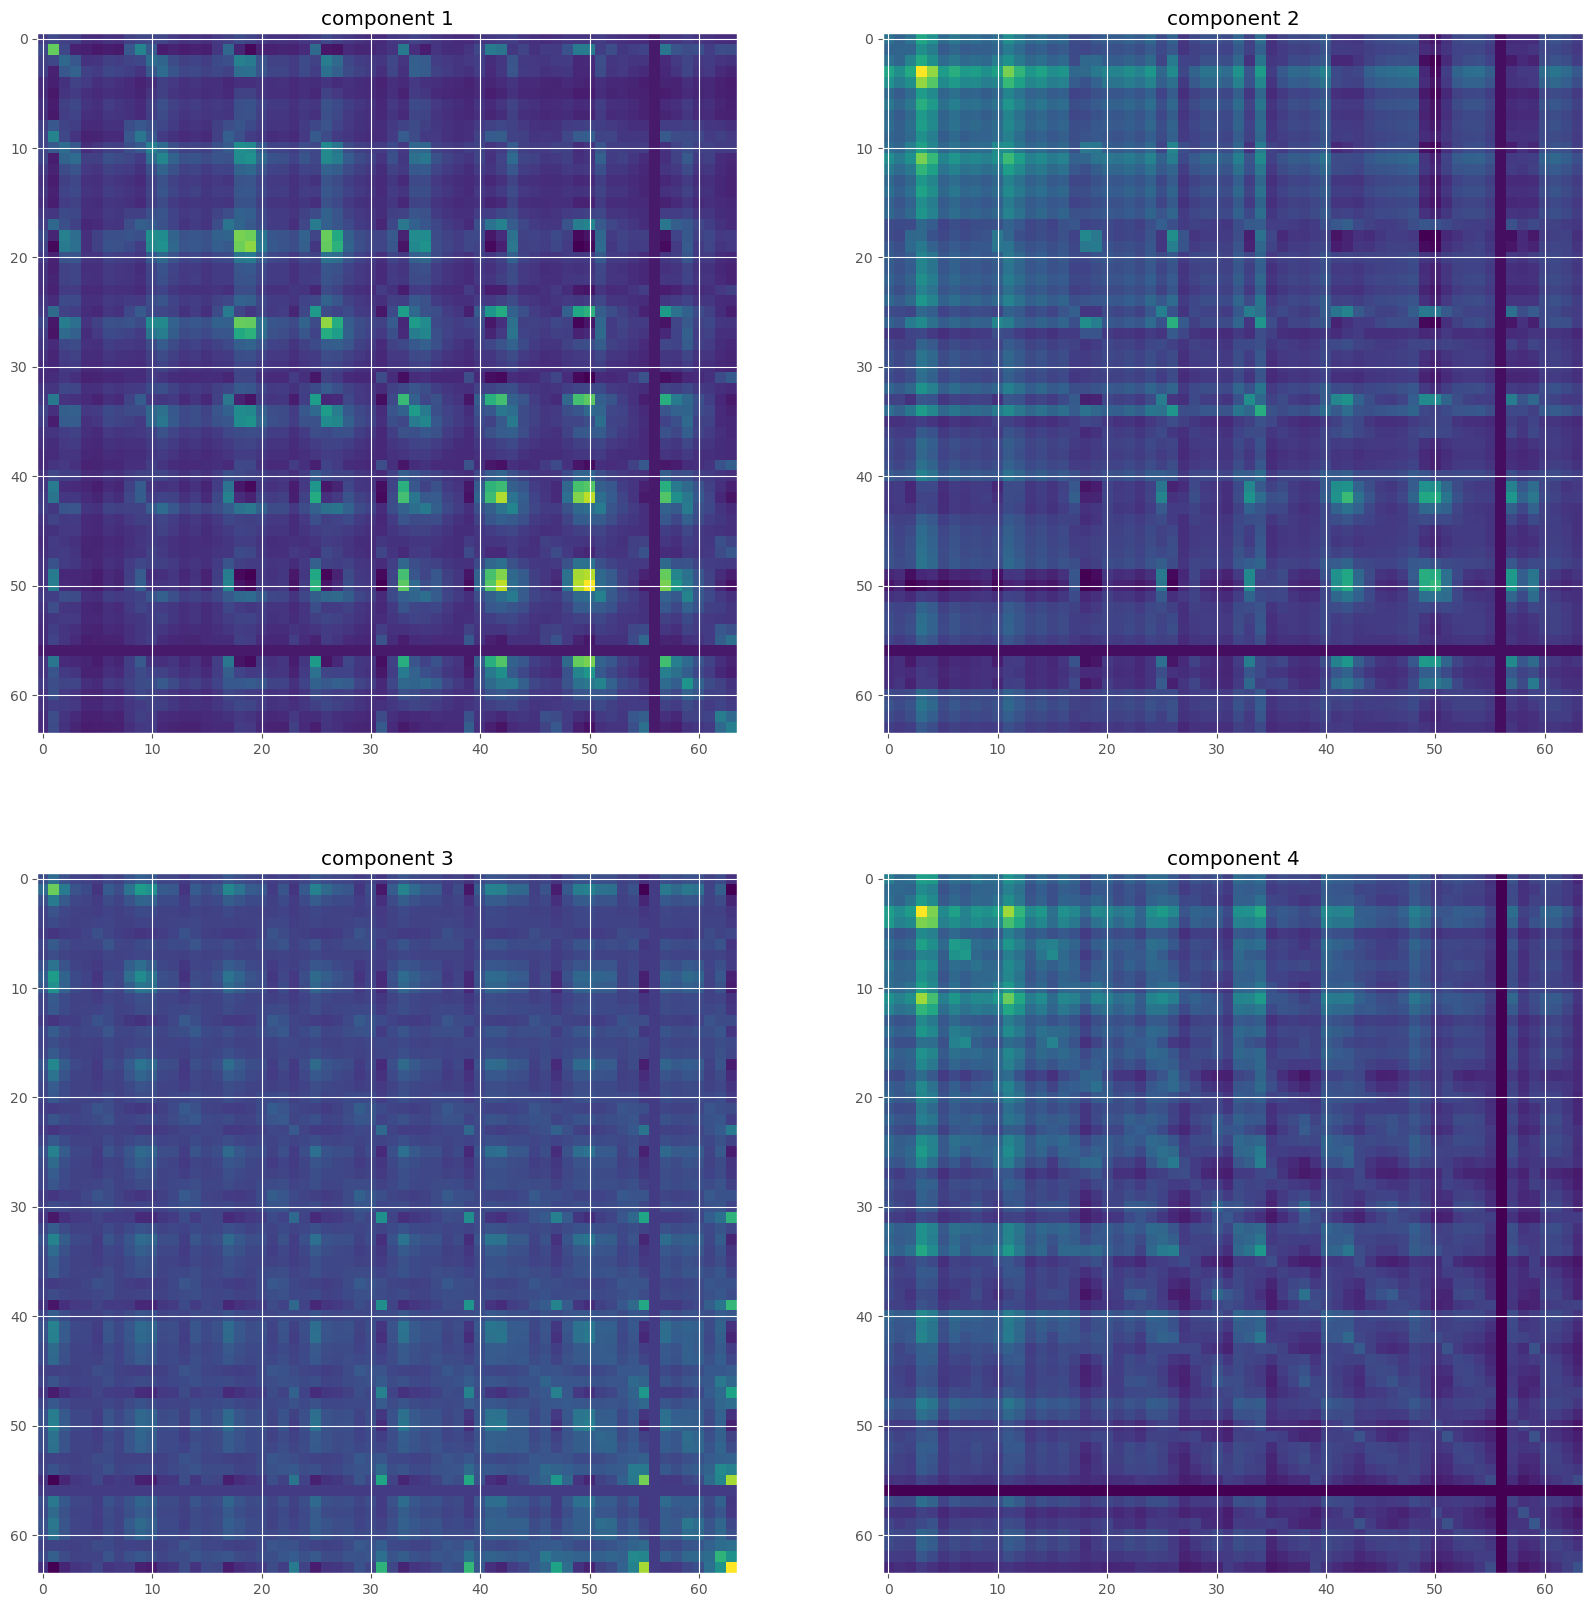

In [13]:
gm = subject_gmms[6]
fig, axes = plt.subplots(2,2,figsize=(20,20))
for i, ax, c in zip(range(1,5), axes.ravel(), gm.covariances_):
    ax.imshow(c)
    ax.set_title(f"component {i}")

## PC1 + PC2 variance

(46, 4)


Text(0.5, 1.0, 'mean top var')

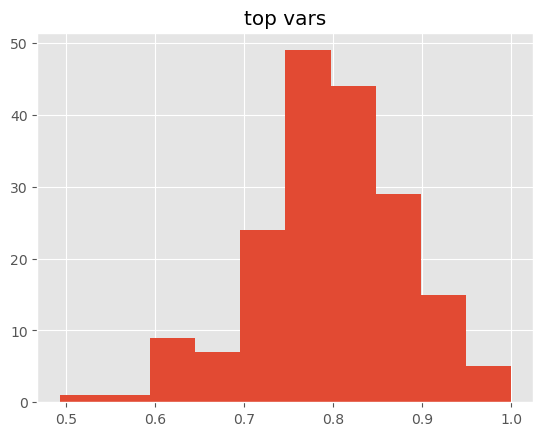

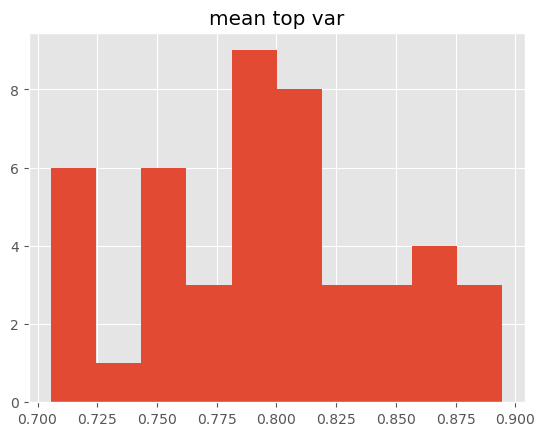

In [14]:
top_pc_vars = []
for gm in subject_gmms:
    pc_vars = []
    for c in gm.covariances_:
        U, S, V = np.linalg.svd(c)
        pc_vars.append((S[0] + S[1]) / S.sum())
    top_pc_vars.append(pc_vars)
top_pc_vars = np.array(top_pc_vars)
print(top_pc_vars.shape)
plt.hist(top_pc_vars.ravel())
plt.title("top vars")
plt.figure()
plt.hist(top_pc_vars.mean(axis=1))
plt.title("mean top var")

### hit fraction vs. avg mixture component PC1 + PC2 var

Text(0, 0.5, 'PC1+PC2 Variance')

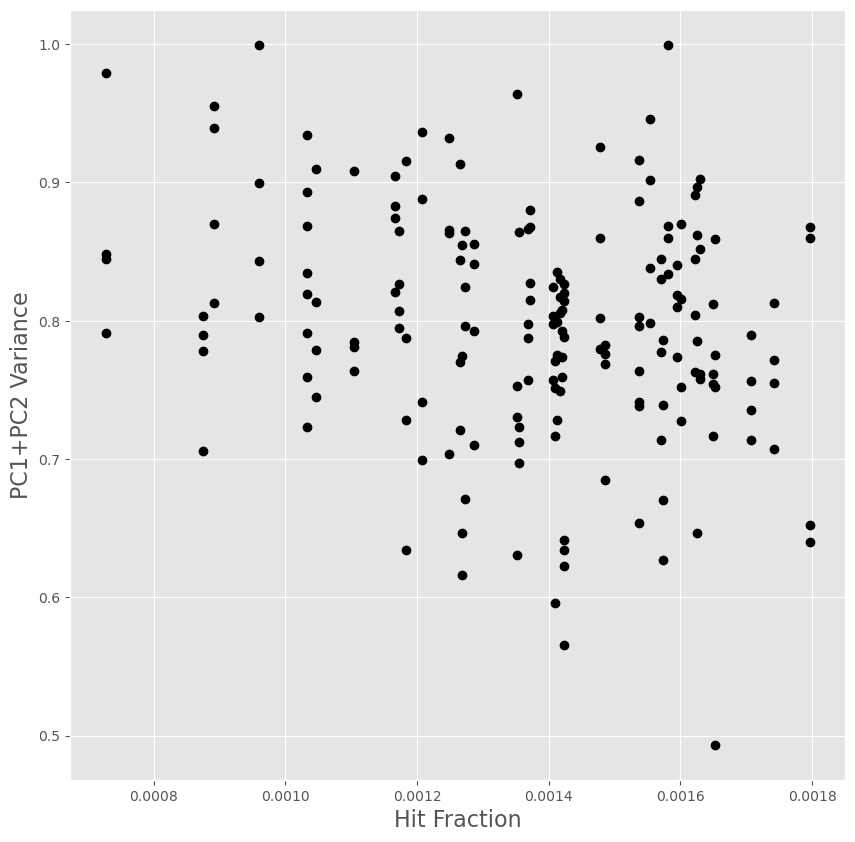

In [15]:
plt.figure(figsize=(10,10))
plt.plot(subject_hit_sums/540,top_pc_vars,"ko")
plt.xlabel("Hit Fraction")
plt.ylabel("PC1+PC2 Variance")


## example subject reconstruct mixture from and decode

In [53]:
subject_idx = 15
subject = subjects[subject_idx]
decoder = subject.decoder[-2:,:]

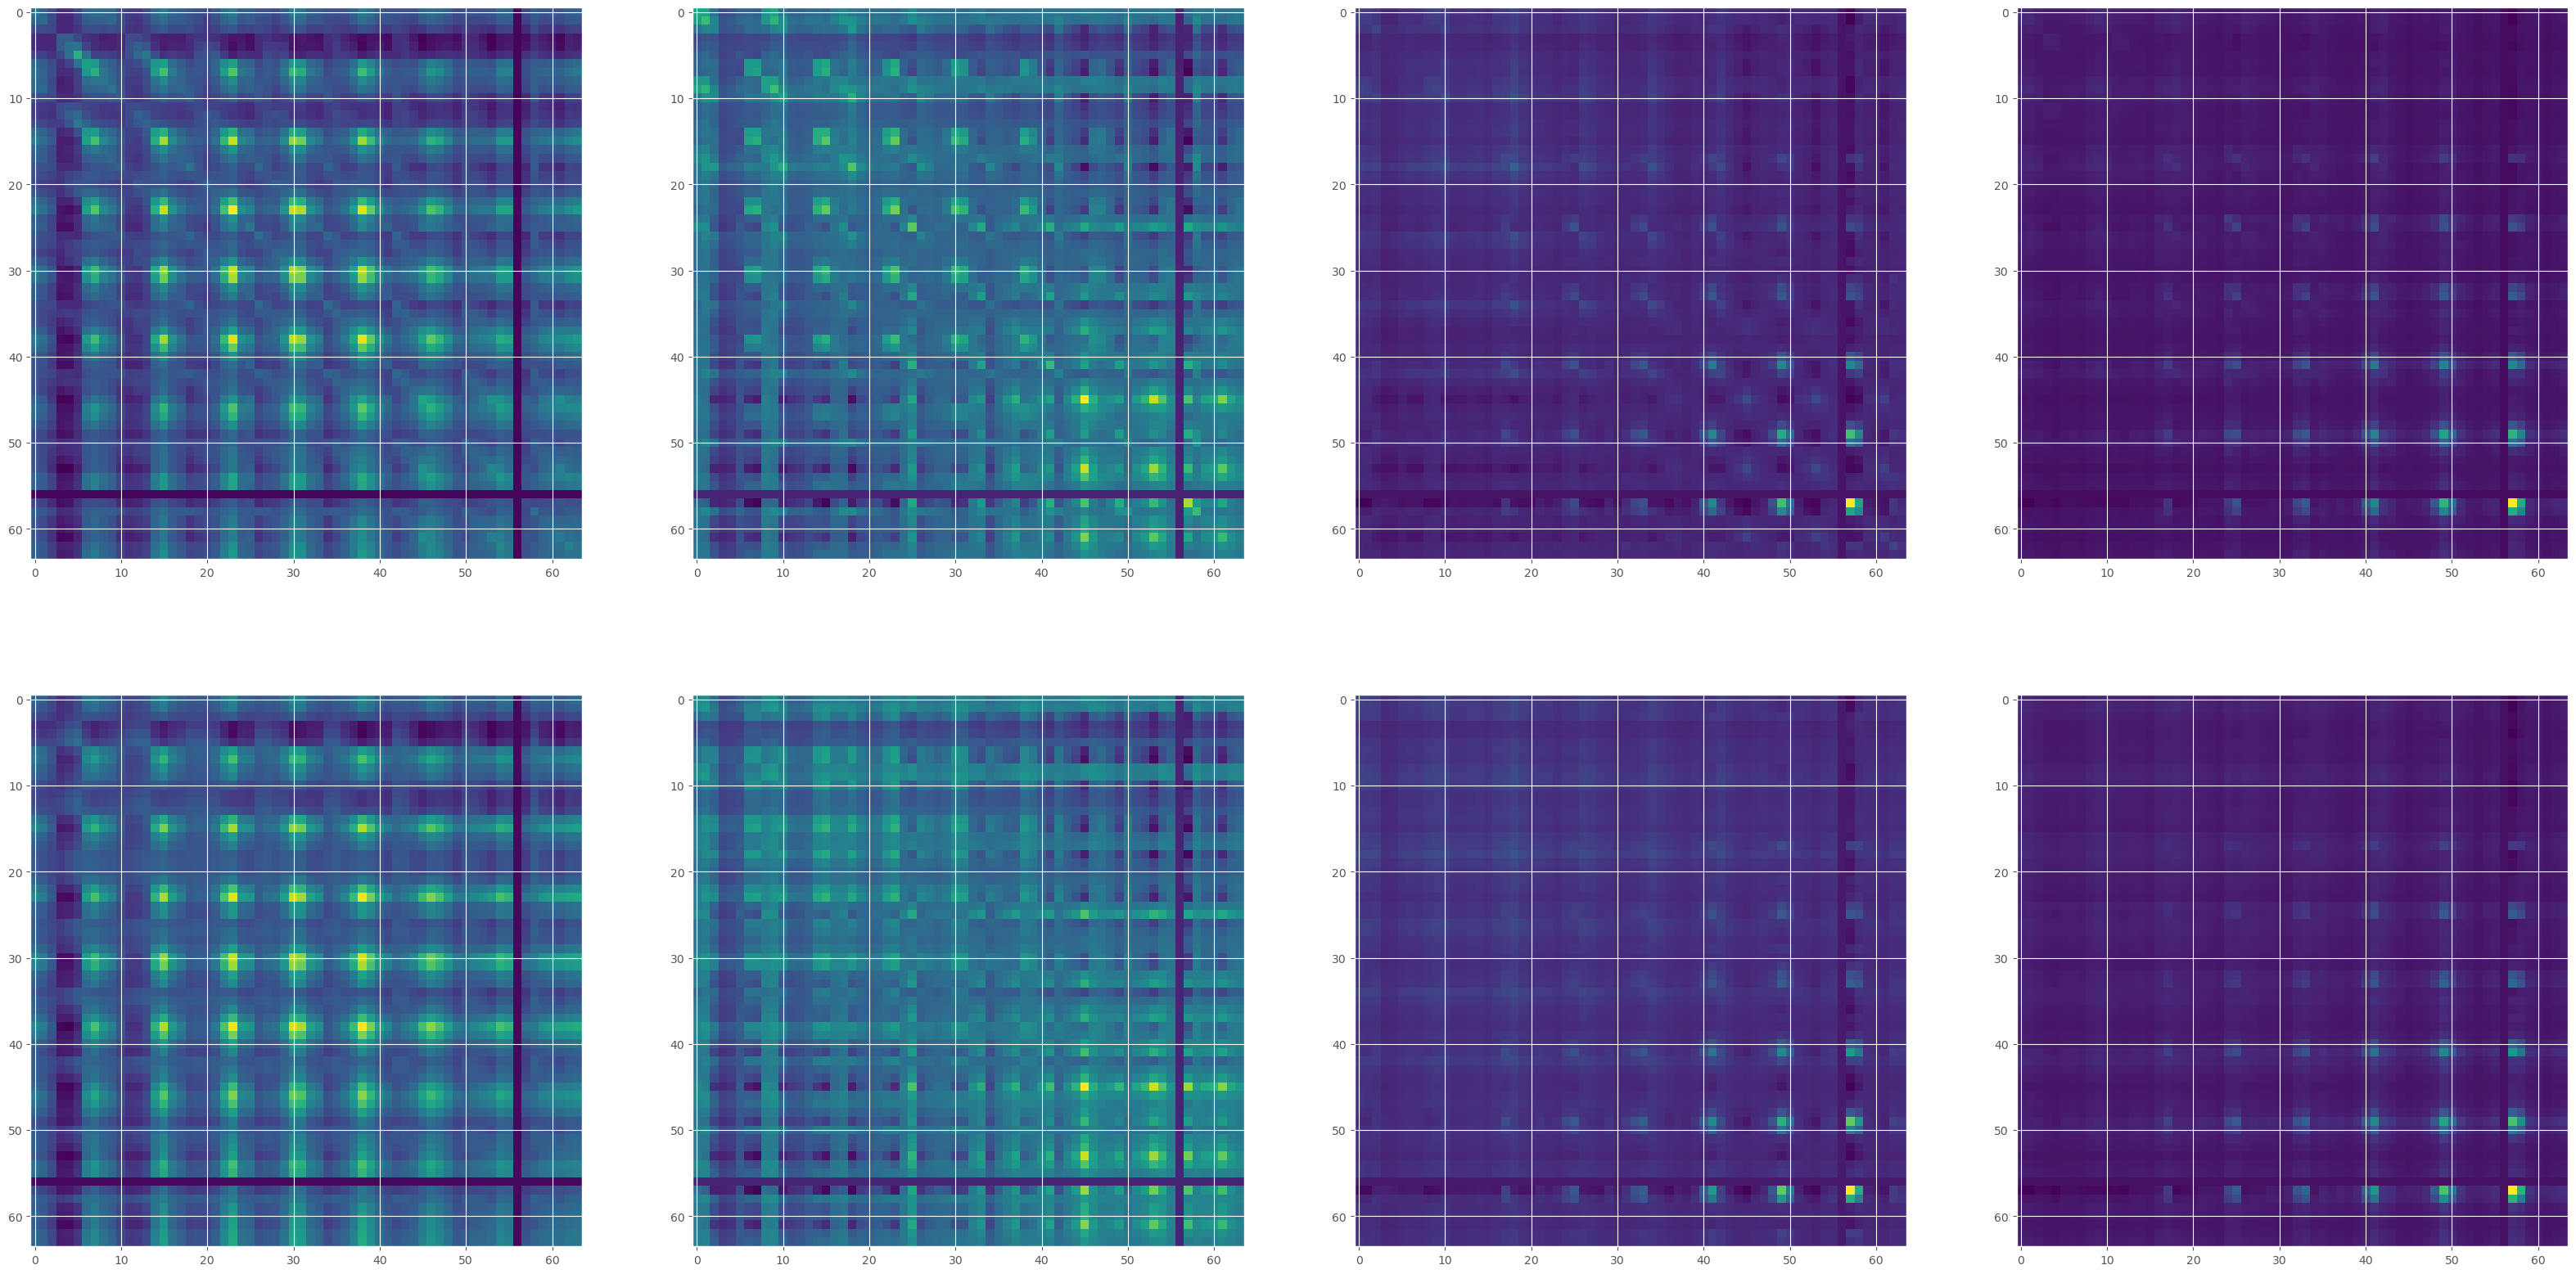

In [54]:
gm = subject_gmms[subject_idx]
fig, axes = plt.subplots(2,4,figsize=(40,20))
for ai, c in enumerate(gm.covariances_):
    U, S, V = np.linalg.svd(c)
    top_vec = U[:,:2].reshape(-1,2)
    reconstructed_cov = np.zeros(shape=(64,64))
    for i, s in enumerate(S[:2]):
        vec = V[i].reshape(1,-1)
        reconstructed_cov += np.outer(s*vec.T, vec)
    axes[0,ai].imshow(c)
    axes[1,ai].imshow(reconstructed_cov)

## the gaussians are low-rank (~2) and thus are confined to affine subspace in the 64D space

i.e. ~4 sets of ~2 channel modes comprise a large amount of signal variance 

### plot the subspace gaussians in PC space

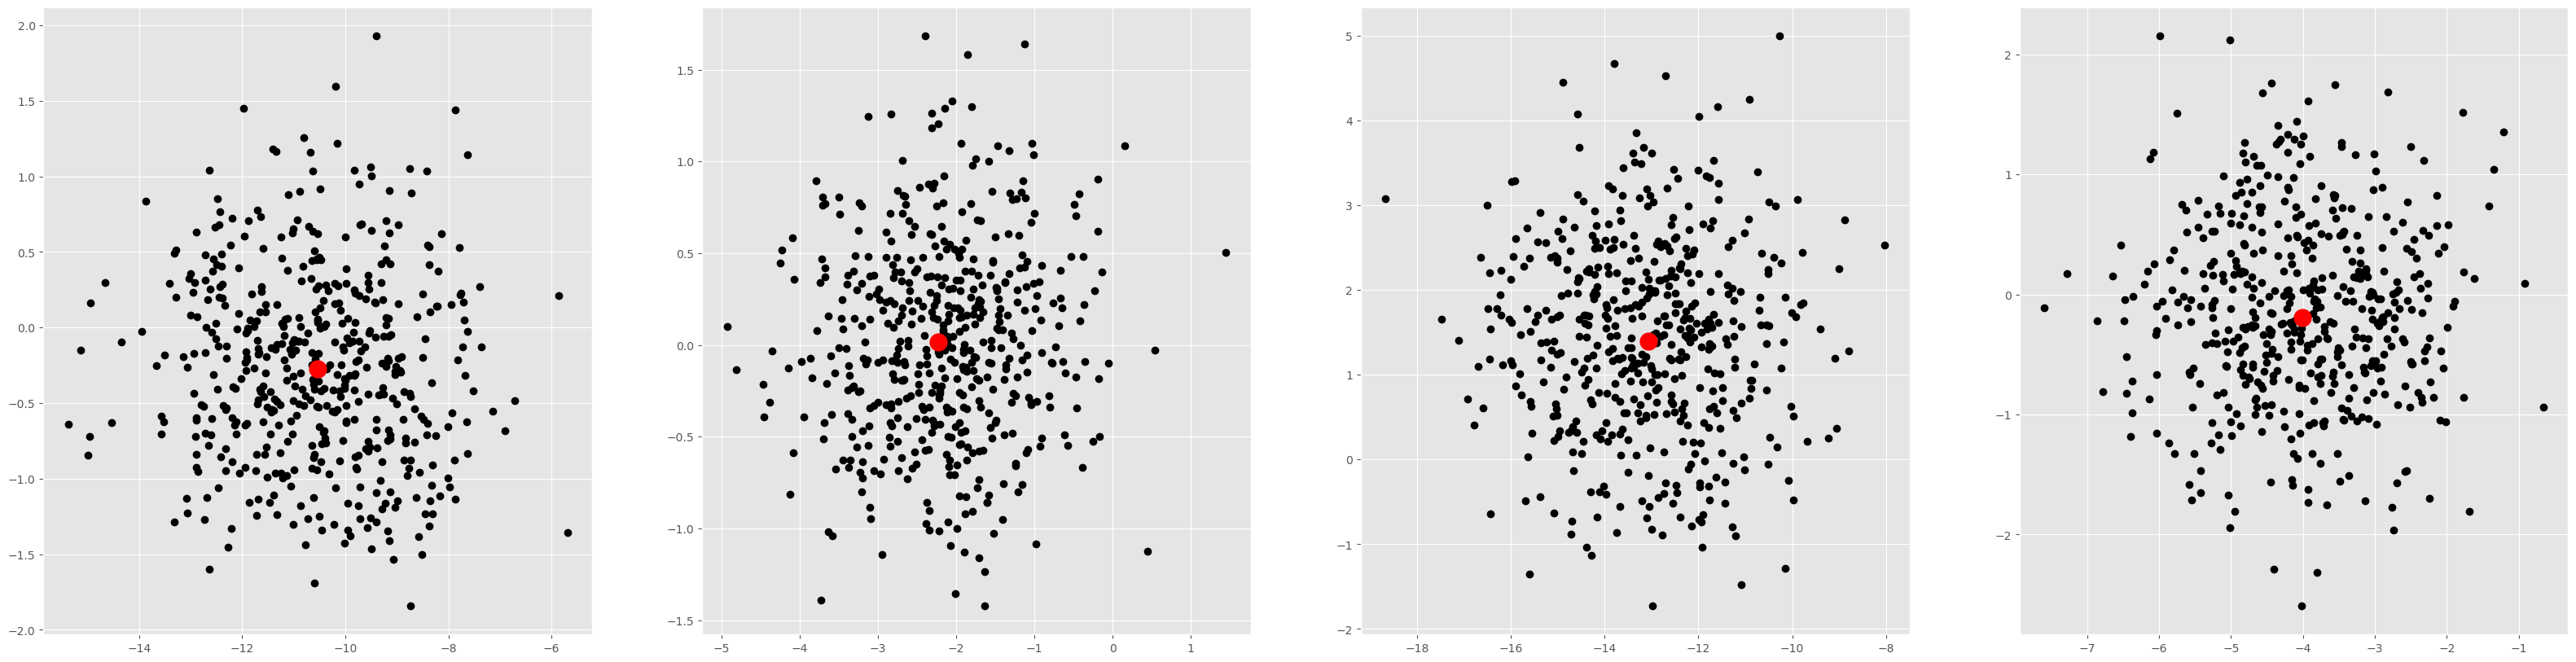

In [55]:
fig, axes = plt.subplots(1,4,figsize=(40,10))
for ai, (c, m) in enumerate(zip(gm.covariances_, gm.means_)):
    U, S, V = np.linalg.svd(c)
    top_vec = U[:,:2].reshape(-1,2)
    s = np.diag(S[:2])
    reduced_mean = (top_vec @ s).T @ m
    reduced_cov = top_vec.T @ top_vec @ s
    samples = np.random.multivariate_normal(reduced_mean,reduced_cov,size=500).T
    axes[ai].plot(samples[0],samples[1],"ko")
    axes[ai].plot(reduced_mean[0],reduced_mean[1],"ro",markersize=15)

## sample from trial fit mixture and decode, compare to trial data

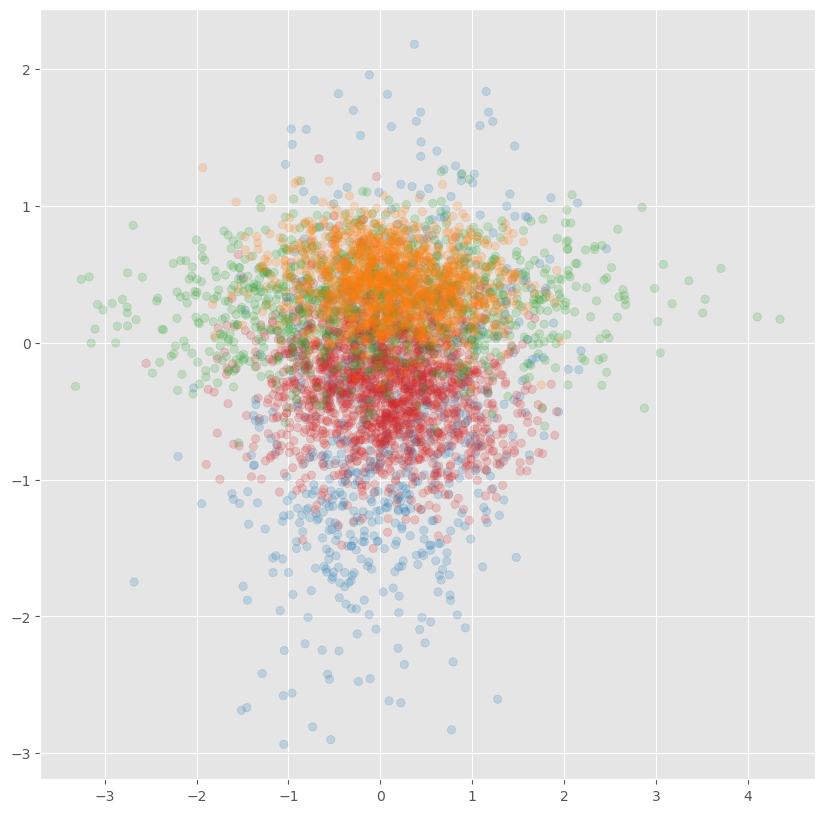

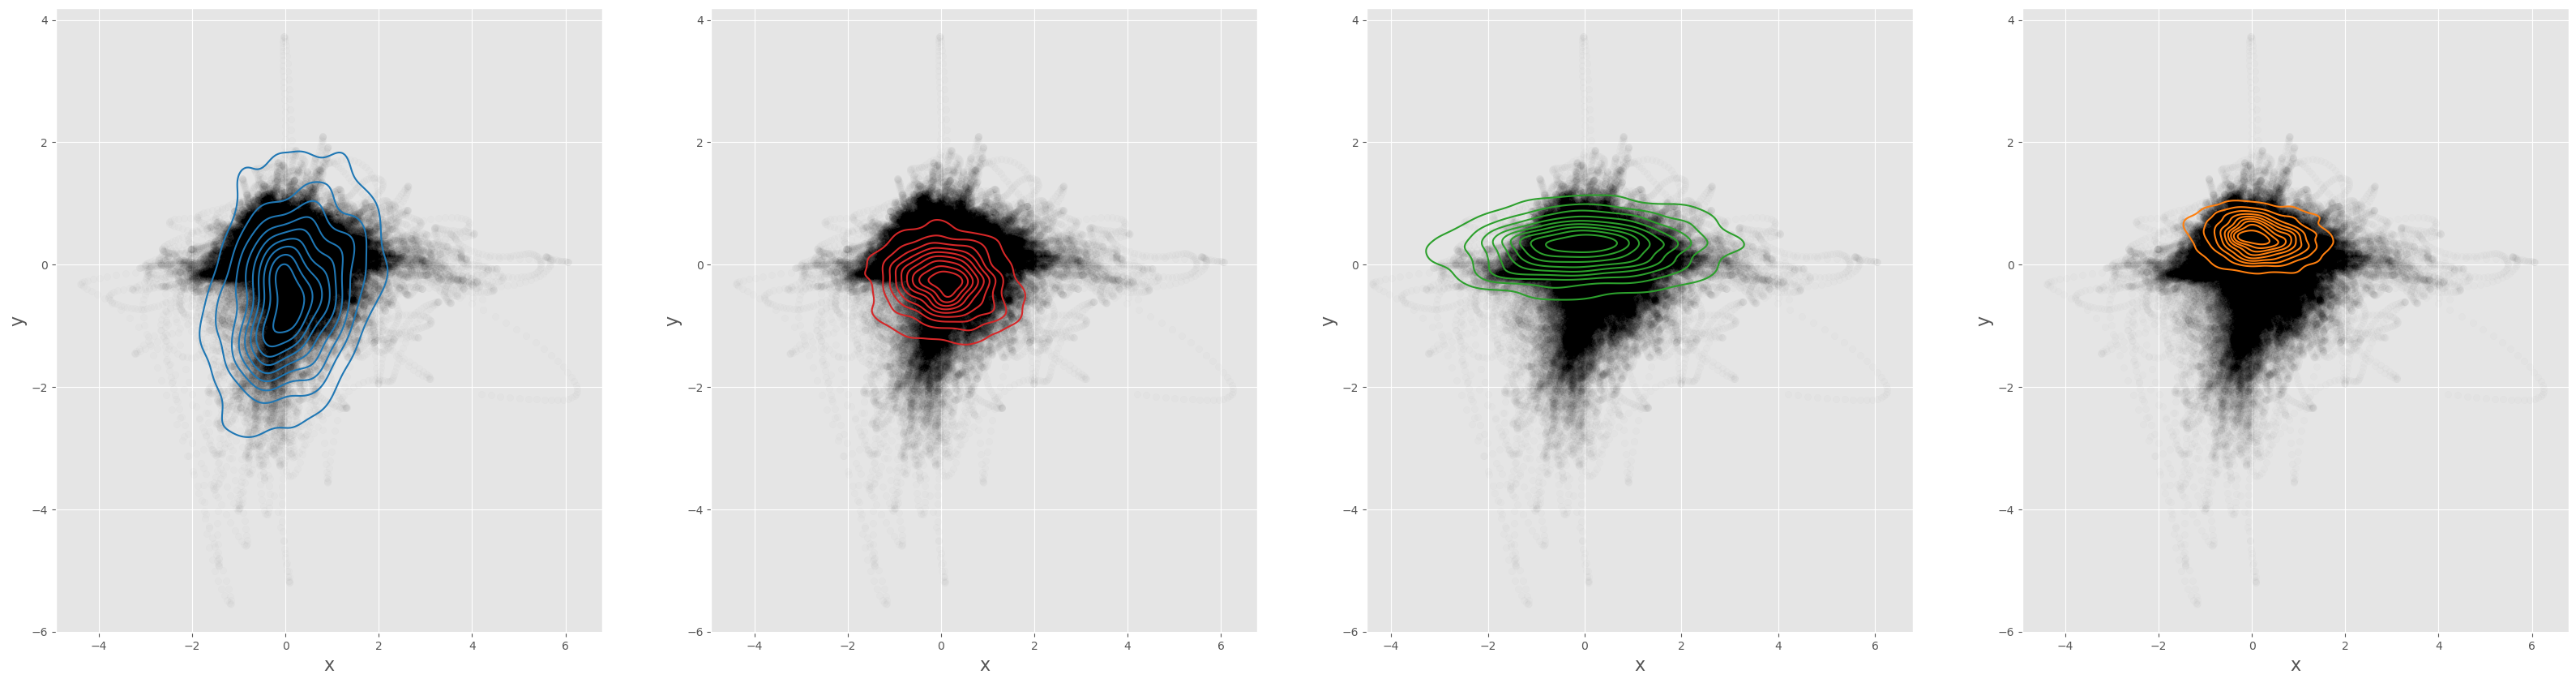

In [56]:
gm = subject_gmms[subject_idx]
samples, mixture_idxs = gm.sample(5000)
decoded_samples = samples @ decoder.T

colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
mixtures = []
for i in range(4):
    mixtures.append(decoded_samples[mixture_idxs == i,:])
color_vec = []
for idx in mixture_idxs:
    color_vec.append(colors[idx])

plt.figure(figsize=(10,10))
plt.scatter(decoded_samples[:,0],decoded_samples[:,1],color=color_vec,alpha=0.2)

traj = subject_traj_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,2)

fig, axes = plt.subplots(1,4,figsize=(40,10))
for i in range(4):
    axes[i].scatter(traj[:,0],traj[:,1],color="k",alpha=0.01)
    df = pd.DataFrame(mixtures[i],columns=["x","y"])
    sns.kdeplot(df,x="x",y="y", color=colors[i],alpha=1.0,ax=axes[i])

## fit "prior" data with gmm

In [39]:
# subject_prior_gmms = []
# for subject_idx in range(46):
#     data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
#     data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
#     data = np.concatenate([data1,data2],axis=0)
#     data = analysis.remove_nan_rows(data)
#     subject_prior_gmms.append(GaussianMixture(n_components=4, random_state=0, max_iter=200).fit(data))

In [40]:
# dump(subject_prior_gmms, "subject_prior_gmms.joblib")

In [41]:
subject_prior_gmms = load("subject_prior_gmms.joblib")

(46, 4)


Text(0.5, 1.0, 'mean top var')

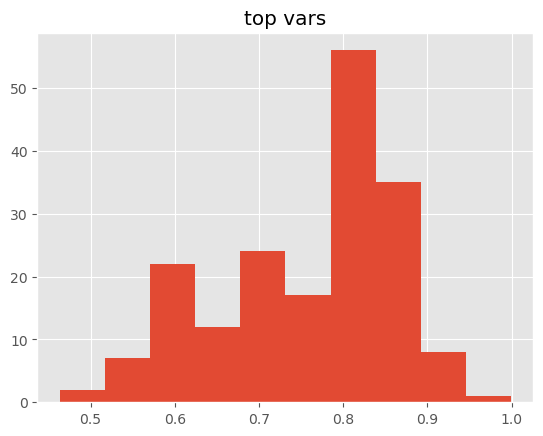

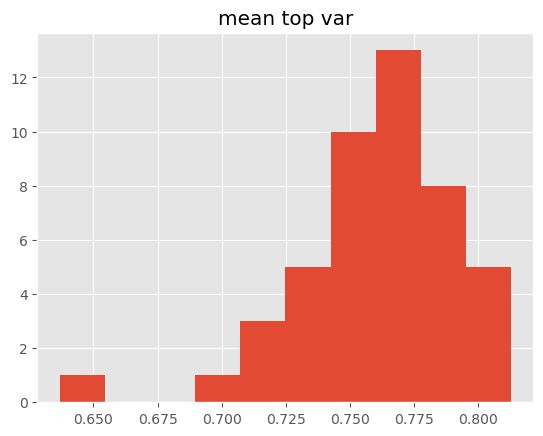

In [42]:
top_pc_vars = []
for gm in subject_prior_gmms:
    pc_vars = []
    for c in gm.covariances_:
        U, S, V = np.linalg.svd(c)
        pc_vars.append((S[0] + S[1]) / S.sum())
    top_pc_vars.append(pc_vars)
top_pc_vars = np.array(top_pc_vars)
print(top_pc_vars.shape)
plt.hist(top_pc_vars.ravel())
plt.title("top vars")
plt.figure()
plt.hist(top_pc_vars.mean(axis=1))
plt.title("mean top var")

### score fit data

In [44]:
subject_model_scores = []
for subject_idx in range(46):
    data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    prior_data = np.concatenate([data1,data2],axis=0)
    prior_data = analysis.remove_nan_rows(prior_data)
    subject_model_scores.append(subject_prior_gmms[subject_idx].score(prior_data))

(array([1., 2., 9., 3., 7., 7., 8., 5., 2., 2.]),
 array([ 84.17469054,  90.35659396,  96.53849737, 102.72040078,
        108.90230419, 115.08420761, 121.26611102, 127.44801443,
        133.62991784, 139.81182126, 145.99372467]),
 <BarContainer object of 10 artists>)

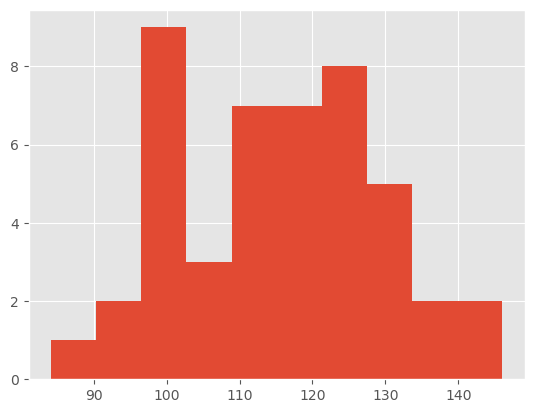

In [45]:
plt.hist(subject_model_scores)

### score trial data

In [47]:
subject_model_scores = []
for subject_idx in range(46):
    trial_samples_channels = subject_emg_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64)
    no_nans = analysis.remove_nan_rows(trial_samples_channels)
    subject_model_scores.append(subject_prior_gmms[subject_idx].score(no_nans))

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3., 41.]),
 array([-6617.15469419, -5950.0674093 , -5282.9801244 , -4615.8928395 ,
        -3948.8055546 , -3281.7182697 , -2614.63098481, -1947.54369991,
        -1280.45641501,  -613.36913011,    53.71815479]),
 <BarContainer object of 10 artists>)

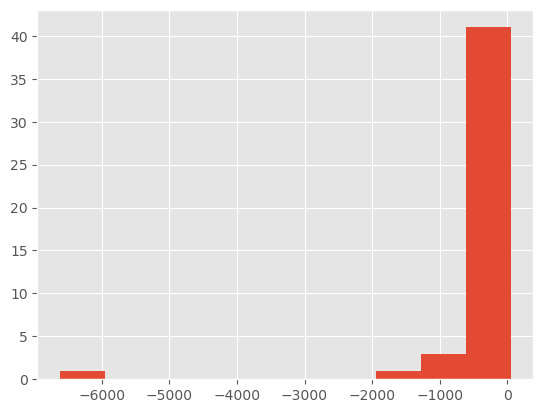

In [48]:
plt.hist(subject_model_scores)

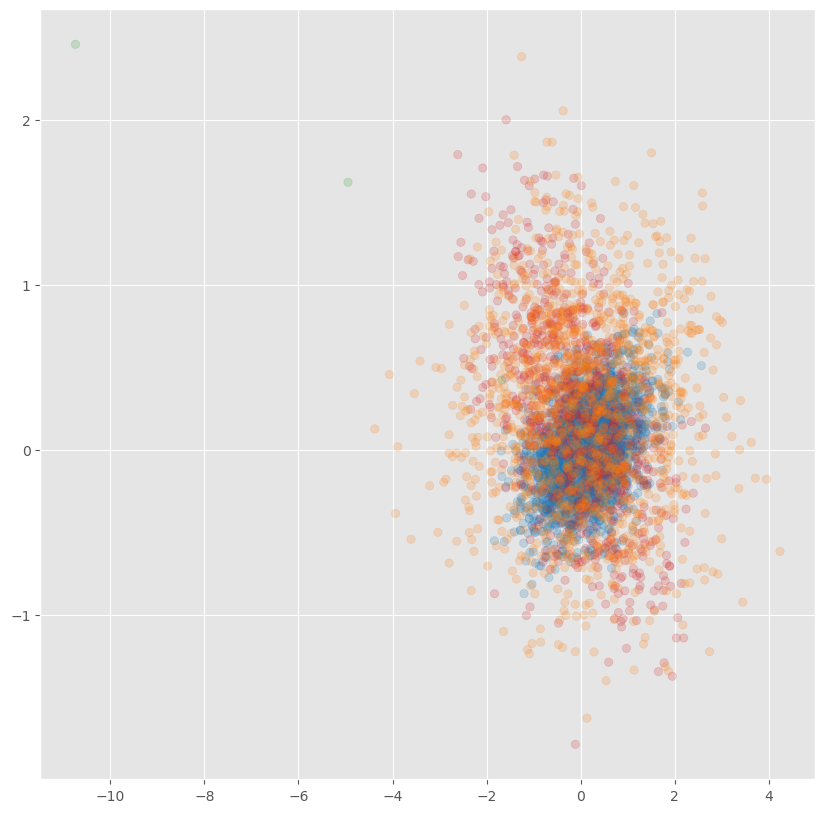

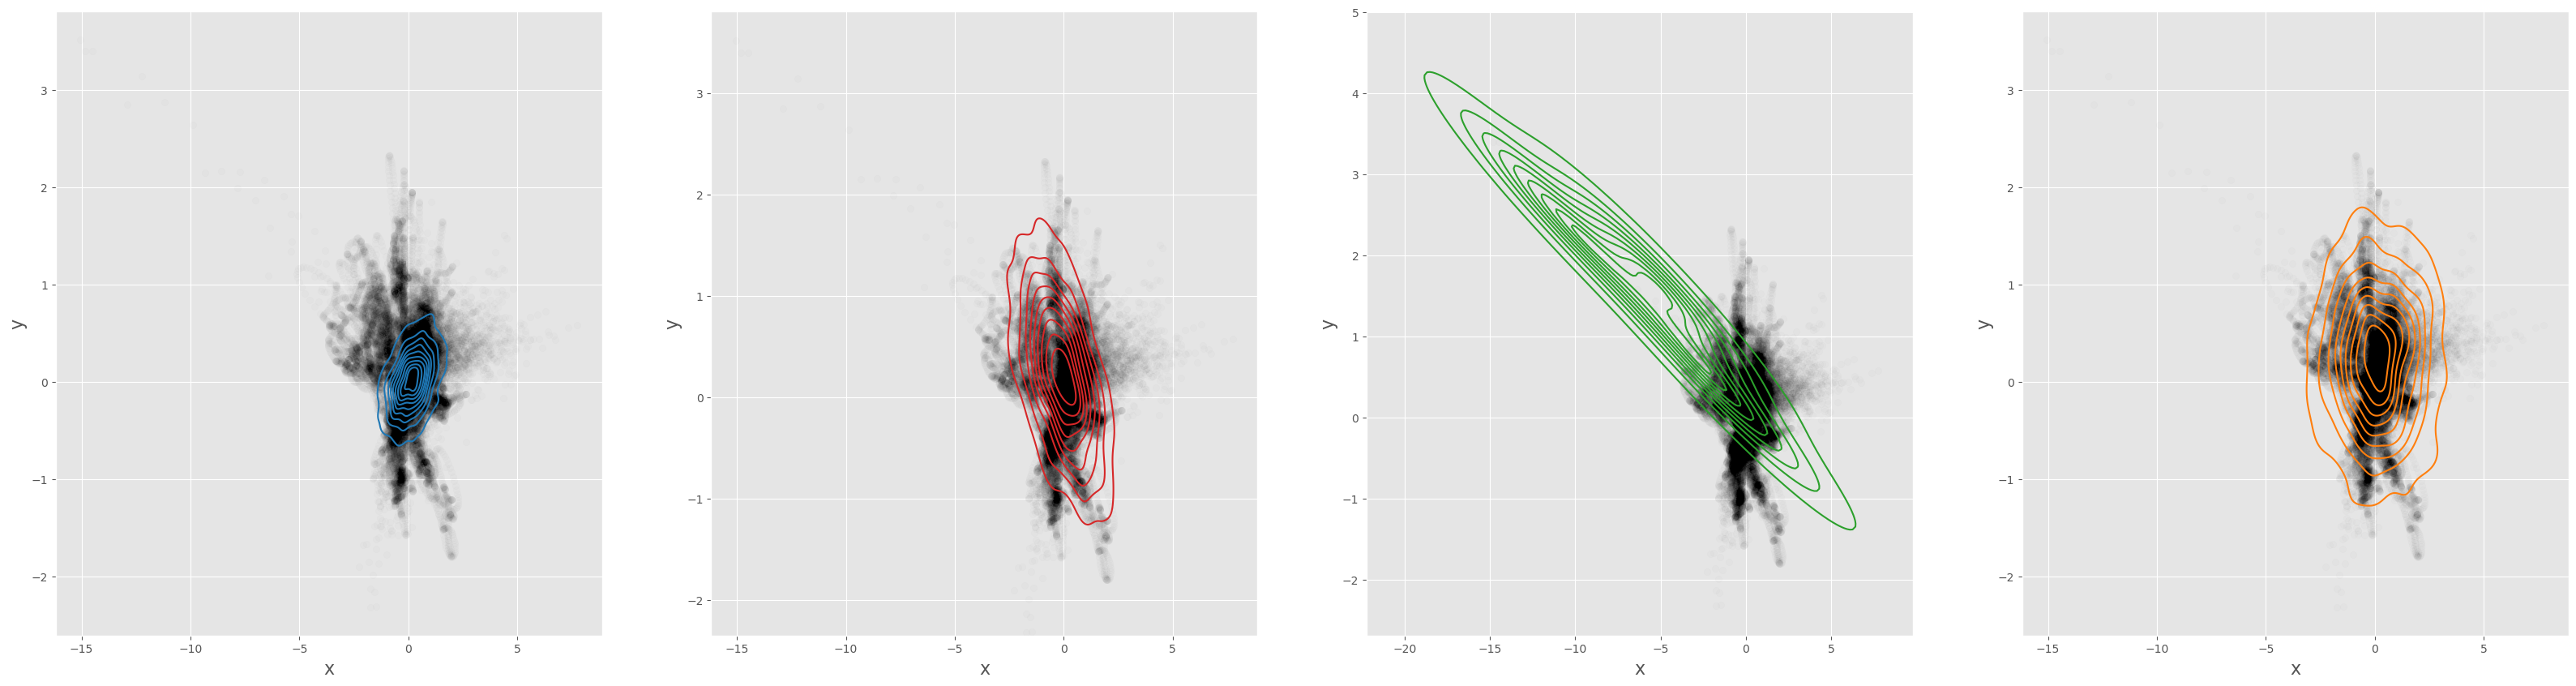

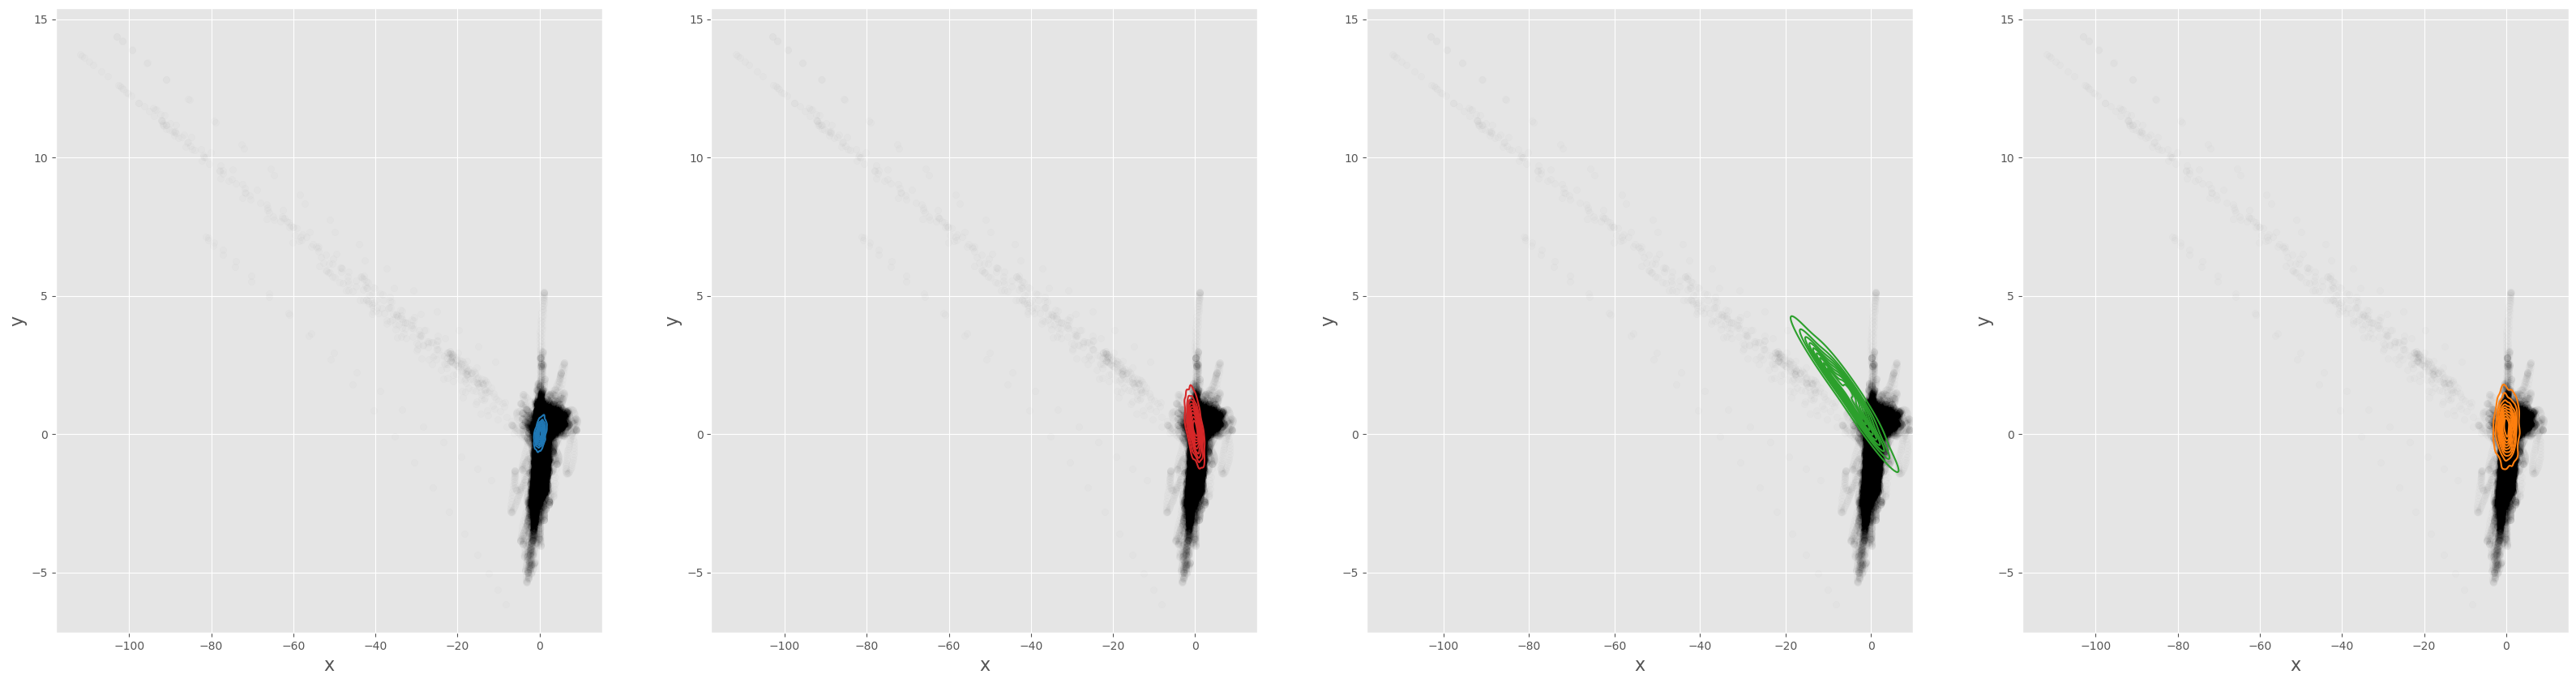

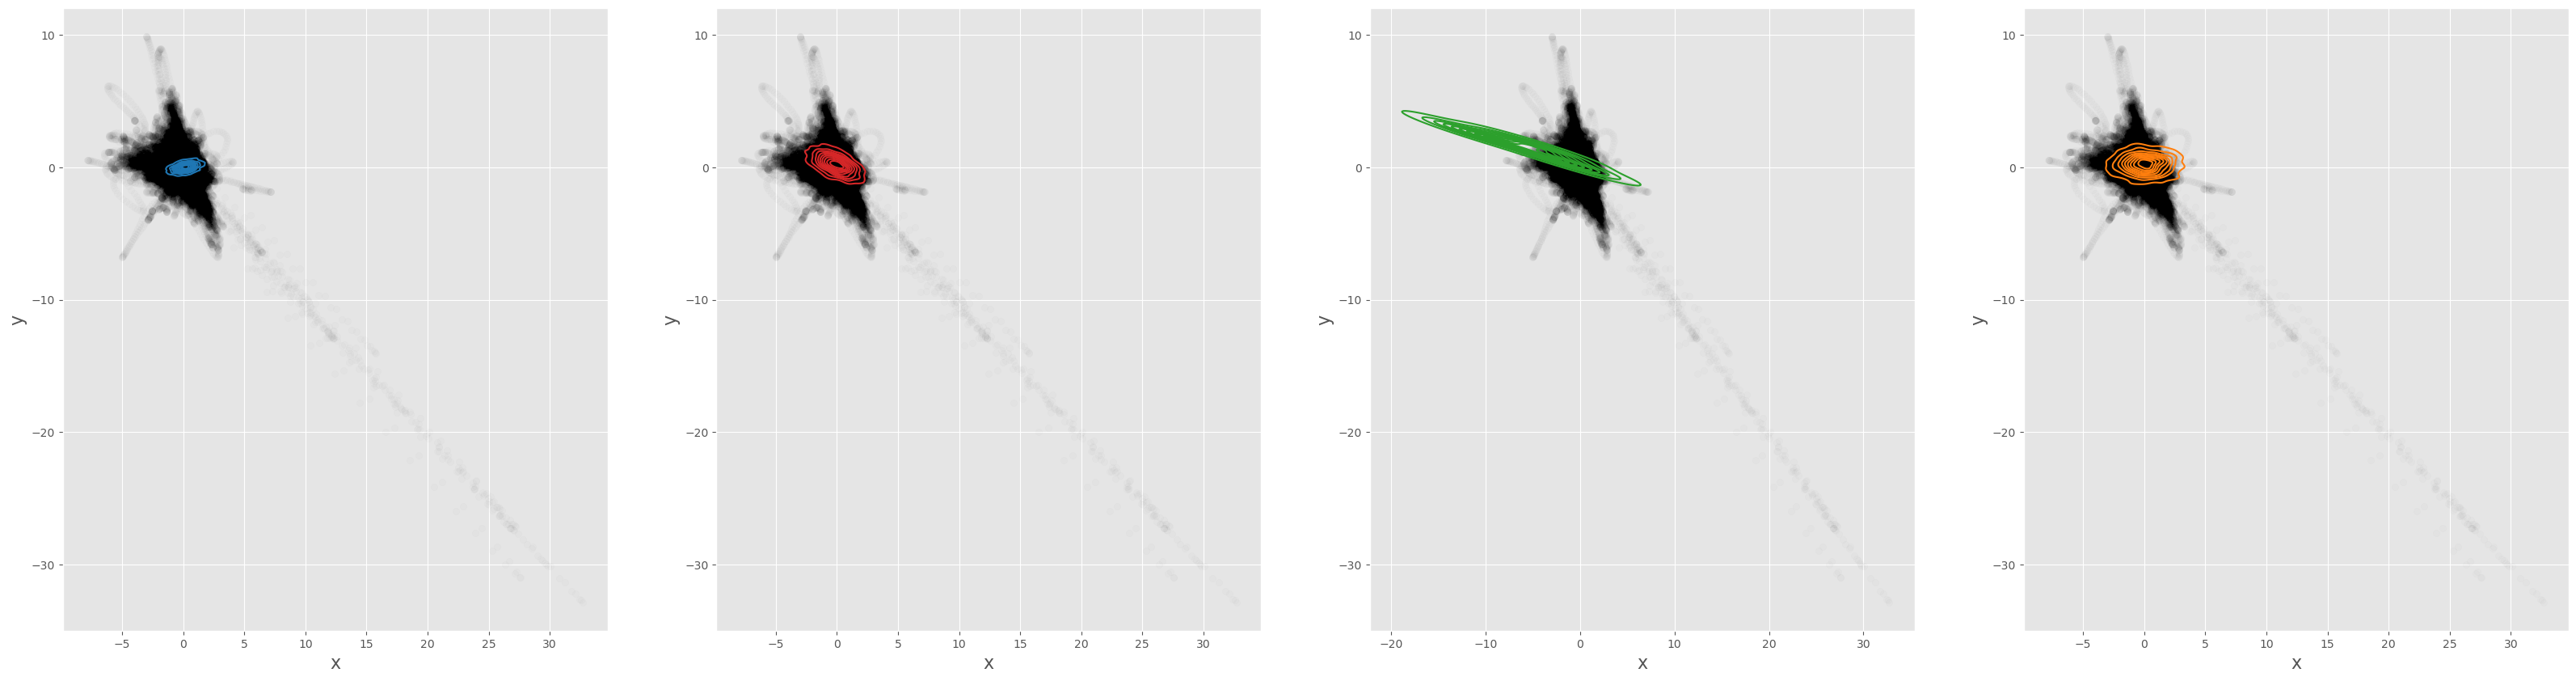

In [51]:
gm = subject_prior_gmms[subject_idx]

samples, mixture_idxs = gm.sample(5000)
decoded_samples = samples @ decoder.T

colors = ["tab:blue", "tab:red", "tab:green", "tab:orange"]
mixtures = []
for i in range(4):
    mixtures.append(decoded_samples[mixture_idxs == i,:])
color_vec = []
for idx in mixture_idxs:
    color_vec.append(colors[idx])

plt.figure(figsize=(10,10))
plt.scatter(decoded_samples[:,0],decoded_samples[:,1],color=color_vec,alpha=0.2)

prior_traj = prior_data @ decoder.T
fig, axes = plt.subplots(1,4,figsize=(40,10))
for i in range(4):
    axes[i].scatter(prior_traj[:,0],prior_traj[:,1],color="k",alpha=0.01)
    df = pd.DataFrame(mixtures[i],columns=["x","y"])
    sns.kdeplot(df,x="x",y="y", color=colors[i],alpha=1.0,ax=axes[i])
    # axes[i].set_xlim([-3,3])
    # axes[i].set_ylim([-3,3])

trial_traj = subject_emg_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,64) @ decoder.T
fig, axes = plt.subplots(1,4,figsize=(40,10))
for i in range(4):
    axes[i].scatter(trial_traj[:,0],trial_traj[:,1],color="k",alpha=0.01)
    df = pd.DataFrame(mixtures[i],columns=["x","y"])
    sns.kdeplot(df,x="x",y="y", color=colors[i],alpha=1.0,ax=axes[i])
    # axes[i].set_xlim([-3,3])
    # axes[i].set_ylim([-3,3])

trial_traj = subject_traj_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,2)
fig, axes = plt.subplots(1,4,figsize=(40,10))
for i in range(4):
    axes[i].scatter(trial_traj[:,0],trial_traj[:,1],color="k",alpha=0.01)
    df = pd.DataFrame(mixtures[i],columns=["x","y"])
    sns.kdeplot(df,x="x",y="y", color=colors[i],alpha=1.0,ax=axes[i])
    # axes[i].set_xlim([-3,3])
    # axes[i].set_ylim([-3,3])
